<a href="https://colab.research.google.com/github/DewliniHerath/Telco_Churn_Predictor/blob/main/notebooks/Telco_DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Data Preprocessing for Decision Tree**

First few steps similar to Neural Network

In [35]:
# import libraries
import pandas as pd
import numpy as np
# mount to google drive
from google.colab import drive
drive.mount('/content/drive')
# remove unecessary errors
import warnings, os
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] ='3' # shows only errors
pd.options.mode.chained_assignment = None
# load data
file_path = '/content/drive/MyDrive/ML_Coursework/Telco-Customer-Churn.csv'
telco_df = pd.read_csv(file_path)
telco_df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [36]:
# dropping customerID (no predictive value)
if "customerID" in telco_df.columns:
    telco_df.drop(columns=["customerID"], inplace=True)
telco_df.head(5)
# dropping TotalCharges directly (redundant feature plus 11 missing values)
if "TotalCharges" in telco_df.columns:
    telco_df.drop(columns=["TotalCharges"], inplace=True)
telco_df.head(5)
# dropping gender to avoid ethical bias
if "gender"in telco_df.columns:
    telco_df.drop(columns=["gender"], inplace=True)
telco_df.head(5)
# handling internet service dependency
service_features = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
for feature in service_features:
  if feature in telco_df.columns:
    telco_df[feature] = telco_df[feature].replace('No internet service','No')
# handling phone service dependency
if 'PhoneService' in telco_df.columns:
    if 'MultipleLines' in telco_df.columns:
        telco_df['MultipleLines'] = telco_df['MultipleLines'].replace('No phone service', 'No')
# defining feature schema
num_features = ["tenure", "MonthlyCharges"]
cat_features = ["InternetService", "Contract", "PaymentMethod"]
bin_features = ["SeniorCitizen", "Dependents", "PhoneService", "PaperlessBilling", "Partner","OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies","MultipleLines"]
# target column  separation
target_col = "Churn"
y = telco_df[target_col].copy()
y = y.map({"Yes": 1, "No": 0})
X = telco_df.drop(columns=[target_col])
# train/test split (stratified)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# class weights
classes = np.array([0,1])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = {cls: w for cls, w in zip(classes, class_weights)}

In [37]:
# encoding categorical variables
from sklearn.preprocessing import LabelEncoder
X_encoded = X.copy()
label_encoders = {}
for col in cat_features + bin_features:
    if col in X_encoded.columns:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded {col}: {len(le.classes_)} categories")
print(f"\nEncoded dataset shape: {X_encoded.shape}")


Encoded InternetService: 3 categories
Encoded Contract: 3 categories
Encoded PaymentMethod: 4 categories
Encoded SeniorCitizen: 2 categories
Encoded Dependents: 2 categories
Encoded PhoneService: 2 categories
Encoded PaperlessBilling: 2 categories
Encoded Partner: 2 categories
Encoded OnlineSecurity: 2 categories
Encoded OnlineBackup: 2 categories
Encoded DeviceProtection: 2 categories
Encoded TechSupport: 2 categories
Encoded StreamingTV: 2 categories
Encoded StreamingMovies: 2 categories
Encoded MultipleLines: 2 categories

Encoded dataset shape: (7043, 17)


In [38]:
# bin tenure (can help decision tree)
X_encoded['tenure_binned'] = pd.cut(X_encoded['tenure'],
                                    bins=[0, 12,24,36,48,100],
                                    labels=[0,1,2,3,4],
                                    include_lowest=True).astype(int)

print("Tenure binned into 5 categories: 0-12, 13-24, 25-36, 37-48, 49+ months")

Tenure binned into 5 categories: 0-12, 13-24, 25-36, 37-48, 49+ months


### **Decision Tree Model Building and Training**

In [39]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np # Import numpy for reproducibility and array operations

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42, stratify=y)

# randomization reproducibility
random.seed(42)
np.random.seed(42)

# hyper parameter tuning
param_grid = {
    'max_depth': [8, 10, 12, 15],
    'min_samples_split': [15, 20, 25, 30],
    'min_samples_leaf': [8, 10, 12, 15],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}
print("Parameter grid for tuning:")
for key, value in param_grid.items():
    print(f"{key}: {value}")

# base model creation
base_dt = DecisionTreeClassifier(class_weight=class_weights_dict,random_state=42)
# grid search with 5 fold cross validation
grid_search = GridSearchCV(estimator=base_dt,
                           param_grid=param_grid,
                           cv=5,
                           scoring='roc_auc',
                           n_jobs=-1,
                           verbose=1)
# fit grid search
grid_search.fit(X_train, y_train)
# get best model
dt_model = grid_search.best_estimator_
print("Best hyperparameters found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

# make predictions
y_pred = dt_model.predict(X_test)
y_pred_proba = dt_model.predict_proba(X_test)[:, 1]

# evaluate model
# classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))
print(confusion_matrix(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")

Parameter grid for tuning:
max_depth: [8, 10, 12, 15]
min_samples_split: [15, 20, 25, 30]
min_samples_leaf: [8, 10, 12, 15]
max_features: ['sqrt', 'log2', None]
criterion: ['gini', 'entropy']
Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Best hyperparameters found:
  criterion: entropy
  max_depth: 8
  max_features: sqrt
  min_samples_leaf: 15
  min_samples_split: 15
Classification Report:
              precision    recall  f1-score   support

           0     0.9059    0.6879    0.7820      1035
           1     0.4815    0.8021    0.6018       374

    accuracy                         0.7182      1409
   macro avg     0.6937    0.7450    0.6919      1409
weighted avg     0.7932    0.7182    0.7342      1409

[[712 323]
 [ 74 300]]
AUC: 0.8158


### **Visualization [Feature importance & Confusion matrix & ROC-AUC]**

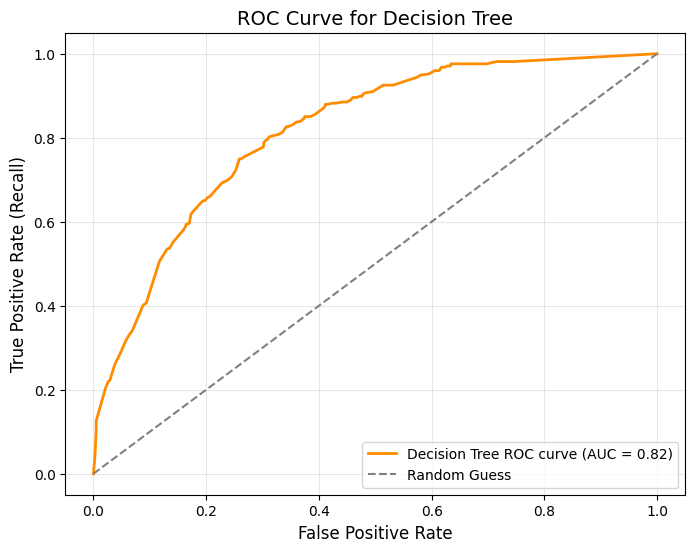

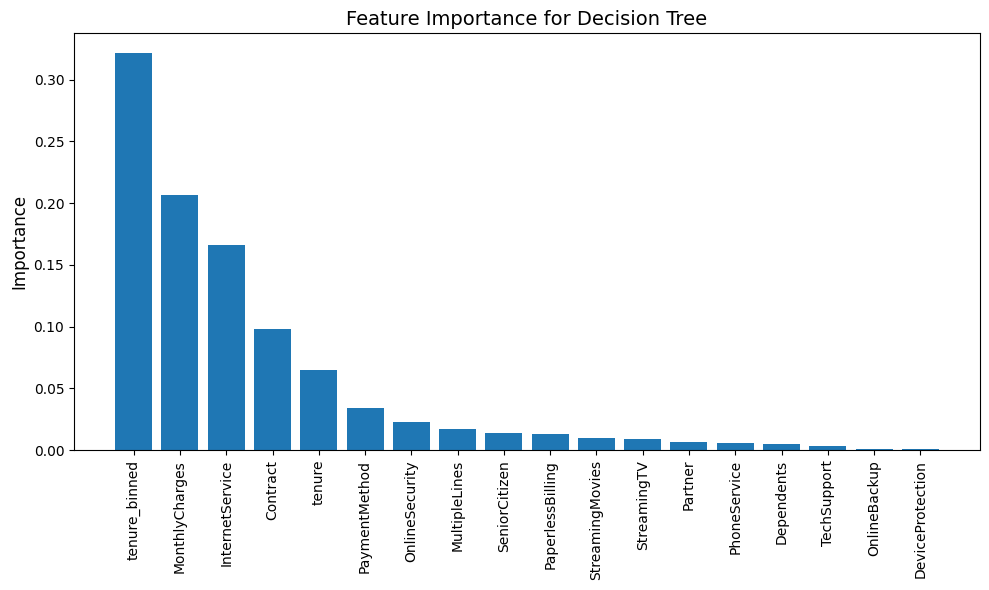

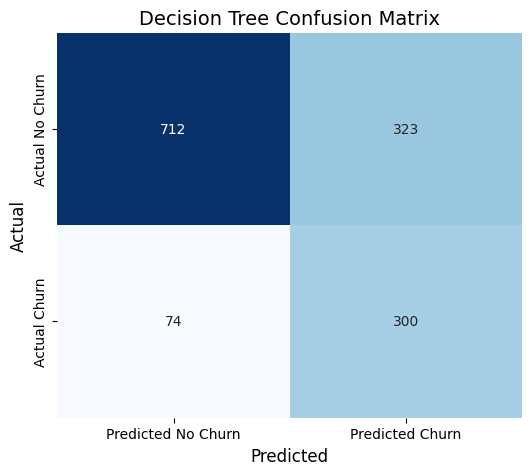

In [40]:
# ROC curve
fpr_dt,tpr_dt,thresholds_dt = roc_curve(y_test, y_pred_proba)
roc_auc_dt = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='darkorange', linewidth=2, label=f'Decision Tree ROC curve (AUC = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate (Recall)", fontsize=12)
plt.title("ROC Curve for Decision Tree",fontsize=14)
plt.legend(loc="lower right")
plt.grid(True,alpha=0.3)
plt.savefig('/content/drive/MyDrive/ML_Coursework/ROC_DT.png')
plt.show()

# Feature importance
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [X_train.columns[i]for i in indices], rotation=90, fontsize=10)
plt.ylabel("Importance", fontsize=12)
plt.title("Feature Importance for Decision Tree", fontsize=14)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/ML_Coursework/Feature_Importance_DT.png')
plt.show()

# Confusion Matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_dt, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted No Churn", "Predicted Churn"], yticklabels=["Actual No Churn", "Actual Churn"])
plt.title("Decision Tree Confusion Matrix",fontsize=14)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.savefig('/content/drive/MyDrive/ML_Coursework/Confusion_Matrix_DT.png')
plt.show()